## LOAD LIBRARIES

In [1]:
#Import all the libraries we need for later use

import numpy as np
import pandas as pd
import nltk
import string
#Bag-of-words, TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Word Embeddings
import pickle
import gensim 
from gensim.models import Word2Vec 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# % matplotlib inline

### .....................................................................................................................................................................................

## LOAD DATA (Cleaned Tweets)

In [2]:
# Retrieve cleaned up tweets for further usage
train_tweets_cleaned = pd.read_pickle("./train_tweets_cleaned.pkl")
# train_tweets_cleaned = train_tweets_cleaned[0:1000]
test_tweets_cleaned = pd.read_pickle("./test_tweets_cleaned.pkl")
# test_tweets_cleaned = test_tweets_cleaned[0:1000]

In [3]:
# tokenized -> sentences
# So that they can be used as arguments in 
# CountVectorizer and TfIdfVectorizer
train_tweets = train_tweets_cleaned['Tweet'].apply(lambda word_list: " ".join(word_list))
train_tweets = train_tweets.tolist()
test_tweets = test_tweets_cleaned['Tweet'].apply(lambda word_list: " ".join(word_list))
test_tweets = test_tweets.tolist()

In [4]:
# Open extra features to add more features
train_extra_features = pd.read_pickle("./train_extra.pkl")
test_extra_features = pd.read_pickle("./test_extra.pkl")

### .....................................................................................................................................................................................


## VECTORIZATION

### BAG OF WORDS

In [18]:
vectorizer = CountVectorizer(strip_accents=None, 
                             tokenizer=lambda x: x.split(), 
                             stop_words=None, 
                             token_pattern='(?u)\b\w\w+\b', 
                             ngram_range=(1, 1), 
                             analyzer='word', 
                             max_df=1.0, min_df=1, max_features=13000, 
                             vocabulary=None, 
                             binary=False)

In [19]:
# TRAIN TWEETS
# Print bag of words
vector = vectorizer.fit_transform(train_tweets)
# Save feature for later training 
pickle.dump(vector, open("./train_tweets_vectorized_BagOfWords.pkl", "wb"))

In [20]:
# TEST TWEETS
# Print bag of words
vector = vectorizer.fit_transform(test_tweets)
# Save feature for later training 
pickle.dump(vector, open("./test_tweets_vectorized_BagOfWords.pkl", "wb"))

### TF-IDF

In [21]:
vectorizer = TfidfVectorizer(strip_accents=None, 
                             tokenizer=lambda x: x.split(), 
                             stop_words=None, 
                             token_pattern='(?u)\b\w\w+\b', 
                             ngram_range=(1, 1), 
                             analyzer='word', 
                             max_df=1.0, min_df=1, max_features=13000, 
                             vocabulary=None, 
                             binary=False)

In [22]:
# TRAIN TWEETS
# Print bag of words
vector = vectorizer.fit_transform(train_tweets)
# Save feature for later training 
pickle.dump(vector, open("./train_tweets_vectorized_TfIdf.pkl", "wb"))

In [23]:
# TEST TWEETS
# Print bag of words
vector = vectorizer.fit_transform(test_tweets)
# Save feature for later training 
pickle.dump(vector, open("./test_tweets_vectorized_TfIdf.pkl", "wb"))

### WORD EMBEDDINGS (word2vec)

In [11]:
# Define vector/feature size
# vs = 50
# vs = 100
# vs = 200
vs = 300

In [12]:
# Train the word2vec model for TRAIN DATA
model_train = Word2Vec(train_tweets_cleaned['Tweet'], min_count=5, size=vs, sg=1, sorted_vocab=1)  
vocabulary_train = list(model_train.wv.vocab)

# Print vocabulary that word2vec created 
# print("Length of vocabulary:", len(vocabulary_train))
# print(vocabulary_train)

# Print most similar words to word 
# print(model_train.wv.most_similar('tomorrow'))
# print(current_similarities)

In [13]:
# Train the word2vec model for TEST DATA
model_test = Word2Vec(test_tweets_cleaned['Tweet'], min_count=5, size=vs, sg=1, sorted_vocab=1)  
vocabulary_test = list(model_test.wv.vocab)

In [14]:
# Save word2vec model for later further use
model_train.save('./train_tweets_word2vec_vs'+str(vs)+'.pkl')
model_test.save('./test_tweets_word2vec_vs'+str(vs)+'.pkl')

##### Extra Features

In [15]:
# Count mean value of similarities of tweets' words with good, bad and tomorrow 
def Add_Similarity_Features(data, extra_features, model, vocabulary):
    for index, row in data.iterrows():
        tweet=row['Tweet']
        for main_word in ['good', 'bad', 'tomorrow']:
            current_similarities = []
            for word in tweet:
                if word in vocabulary:
                    # print(word, main_word, model.wv.similarity(main_word, word))
                    current_similarities.append(model.wv.similarity(main_word, word))
            if len(current_similarities) <= 1:
                if len(current_similarities) == 0:
                    extra_features.at[index,main_word+"_similarity"] = 0
                else:
                    extra_features.at[index,main_word+"_similarity"] = current_similarities[0]
                continue

            # max_sim = max(current_similarities)
            # min_sim = min(current_similarities)
            # normalize to <0;1>
            # current_similarities = [((sim - min_sim) / (max_sim - min_sim)) for sim in current_similarities]  
            extra_features.at[index,main_word+"_similarity"] = np.sum(current_similarities)
            # print( extra_features.at[index,main_word+"_similarity"])
    return extra_features

In [16]:
# Save extra features
train_extra_features = Add_Similarity_Features(train_tweets_cleaned, train_extra_features, model_train, vocabulary_train)
test_extra_features = Add_Similarity_Features(test_tweets_cleaned, test_extra_features, model_test, vocabulary_test)

train_extra_features.to_pickle("./train_extra_vs"+str(vs)+".pkl")
test_extra_features.to_pickle("./test_extra_vs"+str(vs)+".pkl")

#### Visualize word embeddings

/home/peggy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


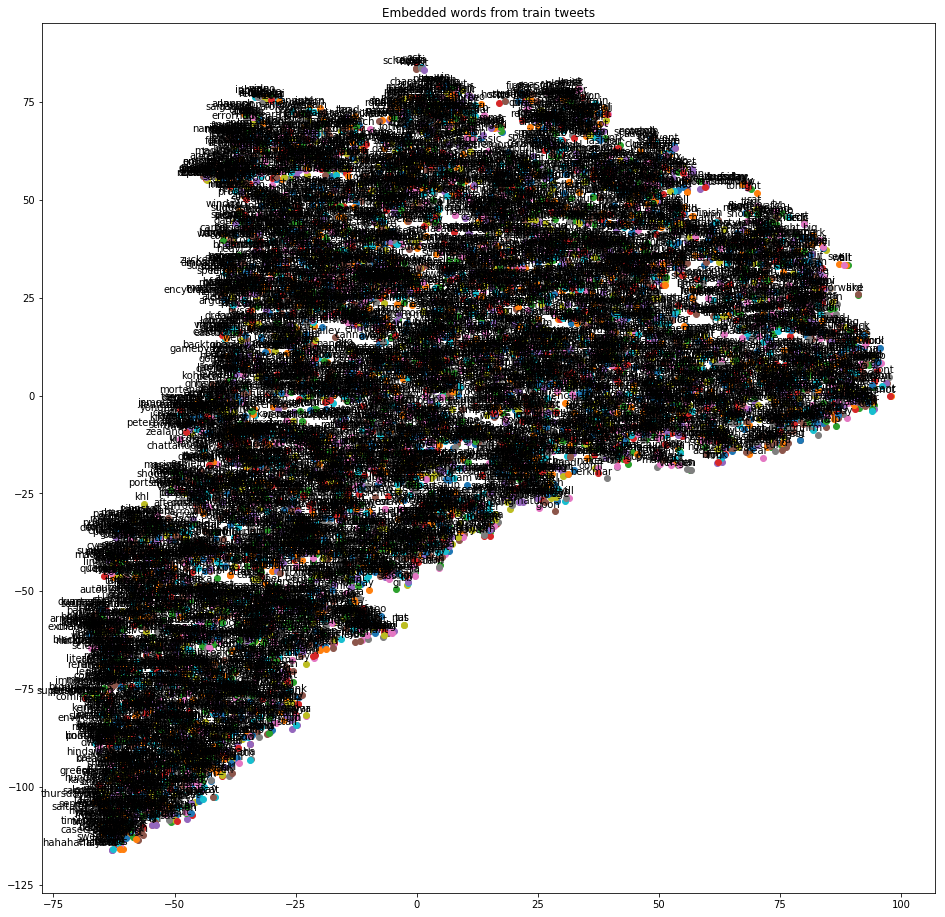

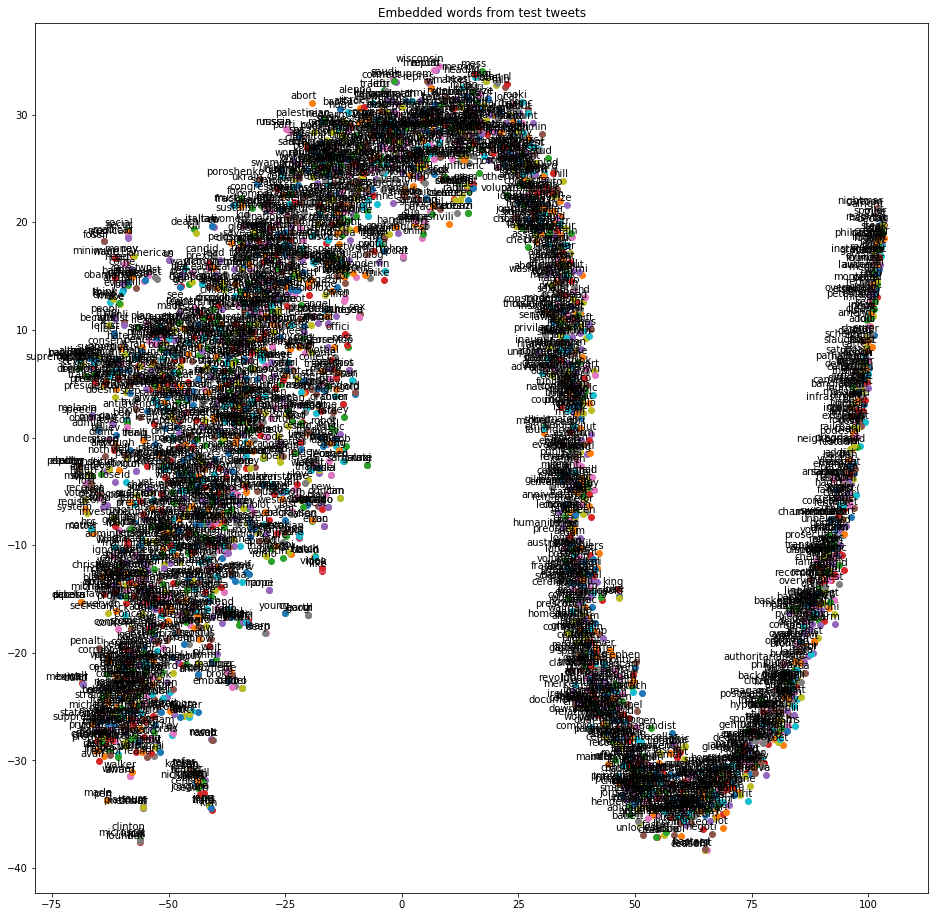

In [17]:
def tsne_plot(model, title, vocabulary):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in vocabulary:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(title)
    plt.show()
    
tsne_plot(model_train, 'Embedded words from train tweets', vocabulary_train)
tsne_plot(model_test, 'Embedded words from test tweets', vocabulary_test)